In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, Dataset, DataLoader
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class CustomImageFolderDataset(Dataset):
    def __init__(self, *paths):
        self.datasets = [datasets.ImageFolder(root=path) for path in paths]
        
        all_classes = sorted(set(cls for ds in self.datasets for cls in ds.classes))
        
        self.class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
        self.classes = all_classes
        
        self.imgs = []
        for ds in self.datasets:
            for img_path, target in ds.imgs:
                new_target = self.class_to_idx[ds.classes[target]]
                self.imgs.append((img_path, new_target))
        
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = Image.open(path).convert('RGB')  
        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
data_dir = '/kaggle/input/fruit-recognition/train/train'
dataset = CustomImageFolderDataset(data_dir)

In [5]:
dataset.classes

['Apple Braeburn',
 'Apple Granny Smith',
 'Apricot',
 'Avocado',
 'Banana',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe',
 'Cherry',
 'Clementine',
 'Corn',
 'Cucumber Ripe',
 'Grape Blue',
 'Kiwi',
 'Lemon',
 'Limes',
 'Mango',
 'Onion White',
 'Orange',
 'Papaya',
 'Passion Fruit',
 'Peach',
 'Pear',
 'Pepper Green',
 'Pepper Red',
 'Pineapple',
 'Plum',
 'Pomegranate',
 'Potato Red',
 'Raspberry',
 'Strawberry',
 'Tomato',
 'Watermelon']

In [6]:
len(dataset)

16854

In [7]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розділіть набір даних
train_data, val_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15), 
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [9]:
len(train_data), len(val_data)

(13484, 3370)

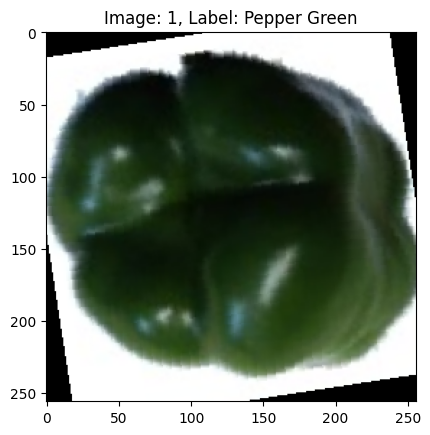

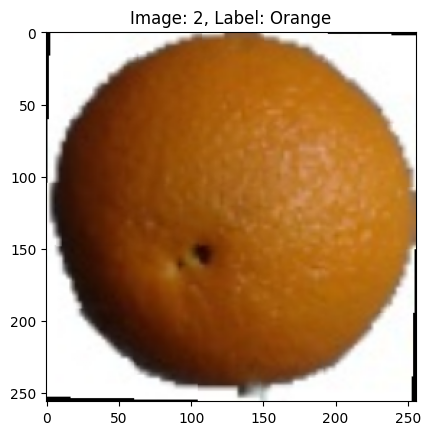

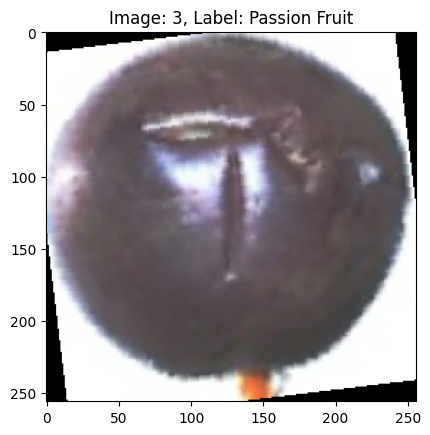

In [10]:
import matplotlib.pyplot as plt

for i in range(3):  # Show 3 images
    img, label = train_data[i]

    # Get the image data (tensor) and convert it back to a NumPy array for manipulation
    img = img.numpy()

    # Convert the color channels from (channels, height, width) to (height, width, channels) for pyplot
    img = img.transpose((1, 2, 0))

    # Get the label name from the dataset class labels
    label_name = dataset.classes[label]

    # Plot the image with a title (including label name)
    plt.imshow(img)
    plt.title(f"Image: {i+1}, Label: {label_name}")
    plt.show()

In [11]:
batch_size = 256

# Створіть завантажувачі даних
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)

In [12]:
import numpy as np
from torch import nn
import torch.nn.functional as F


class FractureClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.drop1 = nn.Dropout(0.2)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flat = nn.Flatten()
        
        self.linear = nn.Linear(32*6*6, num_classes)
        
    def forward(self, x):
        # x - (batch, 3, 256, 256)
        out = self.conv1(x) # (batch, 8, 254, 254)
        out = F.relu(out)
        
        out = self.conv2(out) # (batch, 16, 252, 252)
        out = F.relu(out)
        out = self.drop1(out)
        
        out = self.pool1(out) # (batch, 16, 126, 126)
    
        out = self.conv3(out) # (batch, 32, 124, 124)
        out = F.relu(out)
        
        out = self.pool2(out) # (batch, 32, 62, 62)
        
        out = self.conv4(out) # (batch, 32, 60, 60)
        out = F.relu(out)
        
        
        out = self.pool3(out) # (batch, 32, 30, 30)
        
        out = self.conv5(out) # (batch, 32, 28, 28)
        out = F.relu(out)
        
        out = self.pool4(out) # (batch, 32, 14, 14)
        
        out = self.conv6(out) # (batch, 32, 12, 12)
        out = F.relu(out)
        
        out = self.pool5(out) # (batch, 32, 6, 6)
        
        out = self.flat(out) # (batch, 32*6*6)
        
        out = self.linear(out) #(batch, num_class)
        
        return out
    
    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()


model = FractureClassifier(len(dataset.classes)).to(device)
model

FractureClassifier(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (drop1): Dropout(p=0.2, inplace=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=1152, out_features=33, bias=True)
)

In [13]:
!pip install -q torchsummary

In [14]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]             224
            Conv2d-2         [-1, 16, 252, 252]           1,168
           Dropout-3         [-1, 16, 252, 252]               0
         MaxPool2d-4         [-1, 16, 126, 126]               0
            Conv2d-5         [-1, 32, 124, 124]           4,640
         MaxPool2d-6           [-1, 32, 62, 62]               0
            Conv2d-7           [-1, 32, 60, 60]           9,248
         MaxPool2d-8           [-1, 32, 30, 30]               0
            Conv2d-9           [-1, 32, 28, 28]           9,248
        MaxPool2d-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 12, 12]           9,248
        MaxPool2d-12             [-1, 32, 6, 6]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14                   

In [15]:
# Визначення функції втрат та оптимізатора

loss_fn = nn.CrossEntropyLoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass
    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}
        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)
        
        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)
            
        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history


In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=FractureClassifier, opt=Adam(lr=0.001000), epochs=10, device=cuda

Epoch    1  135sec	loss:       2.58	val_loss:       1.44	accuracy_score:      0.231	val_accuracy_score:      0.566	
Epoch    2   73sec	loss:      0.926	val_loss:      0.644	accuracy_score:        0.7	val_accuracy_score:      0.795	
Epoch    3   76sec	loss:      0.482	val_loss:      0.369	accuracy_score:      0.832	val_accuracy_score:      0.883	
Epoch    4   74sec	loss:      0.291	val_loss:      0.218	accuracy_score:      0.897	val_accuracy_score:      0.923	
Epoch    5   76sec	loss:       0.18	val_loss:      0.124	accuracy_score:      0.936	val_accuracy_score:      0.964	
Epoch    6   79sec	loss:      0.155	val_loss:     0.0831	accuracy_score:      0.946	val_accuracy_score:      0.979	
Epoch    7   77sec	loss:      0.132	val_loss:      0.092	accuracy_score:      0.953	val_accuracy_score:       0.97	
Epoch    8   78sec	loss:     0.0796	val_loss:     0.0512	accuracy_score:      0.974	val_accuracy_sc

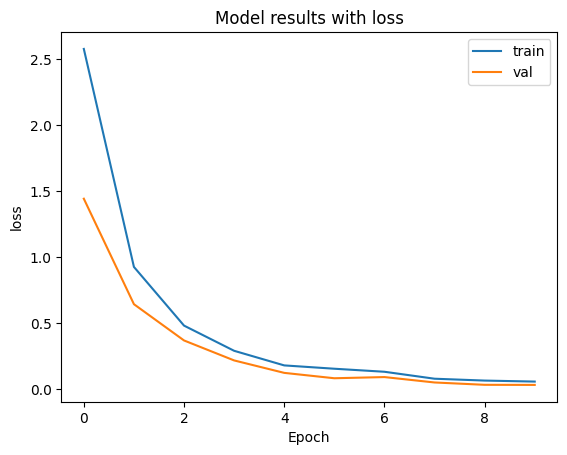

In [18]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

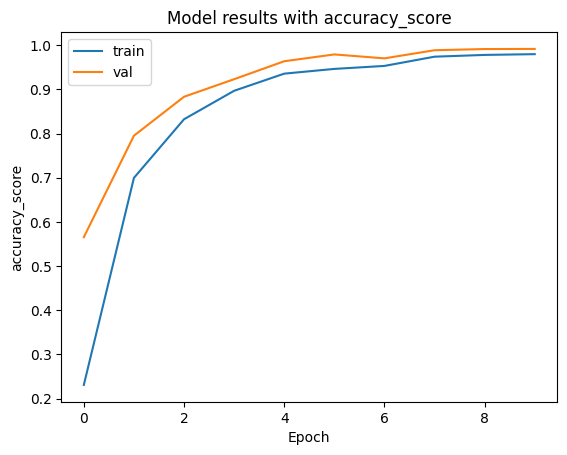

In [19]:
plot_metric(history, 'accuracy_score')

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cuda')  # відключаємо від gpu

loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset.classes)
plt.xticks(rotation=90)
plt.plot()

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

[]

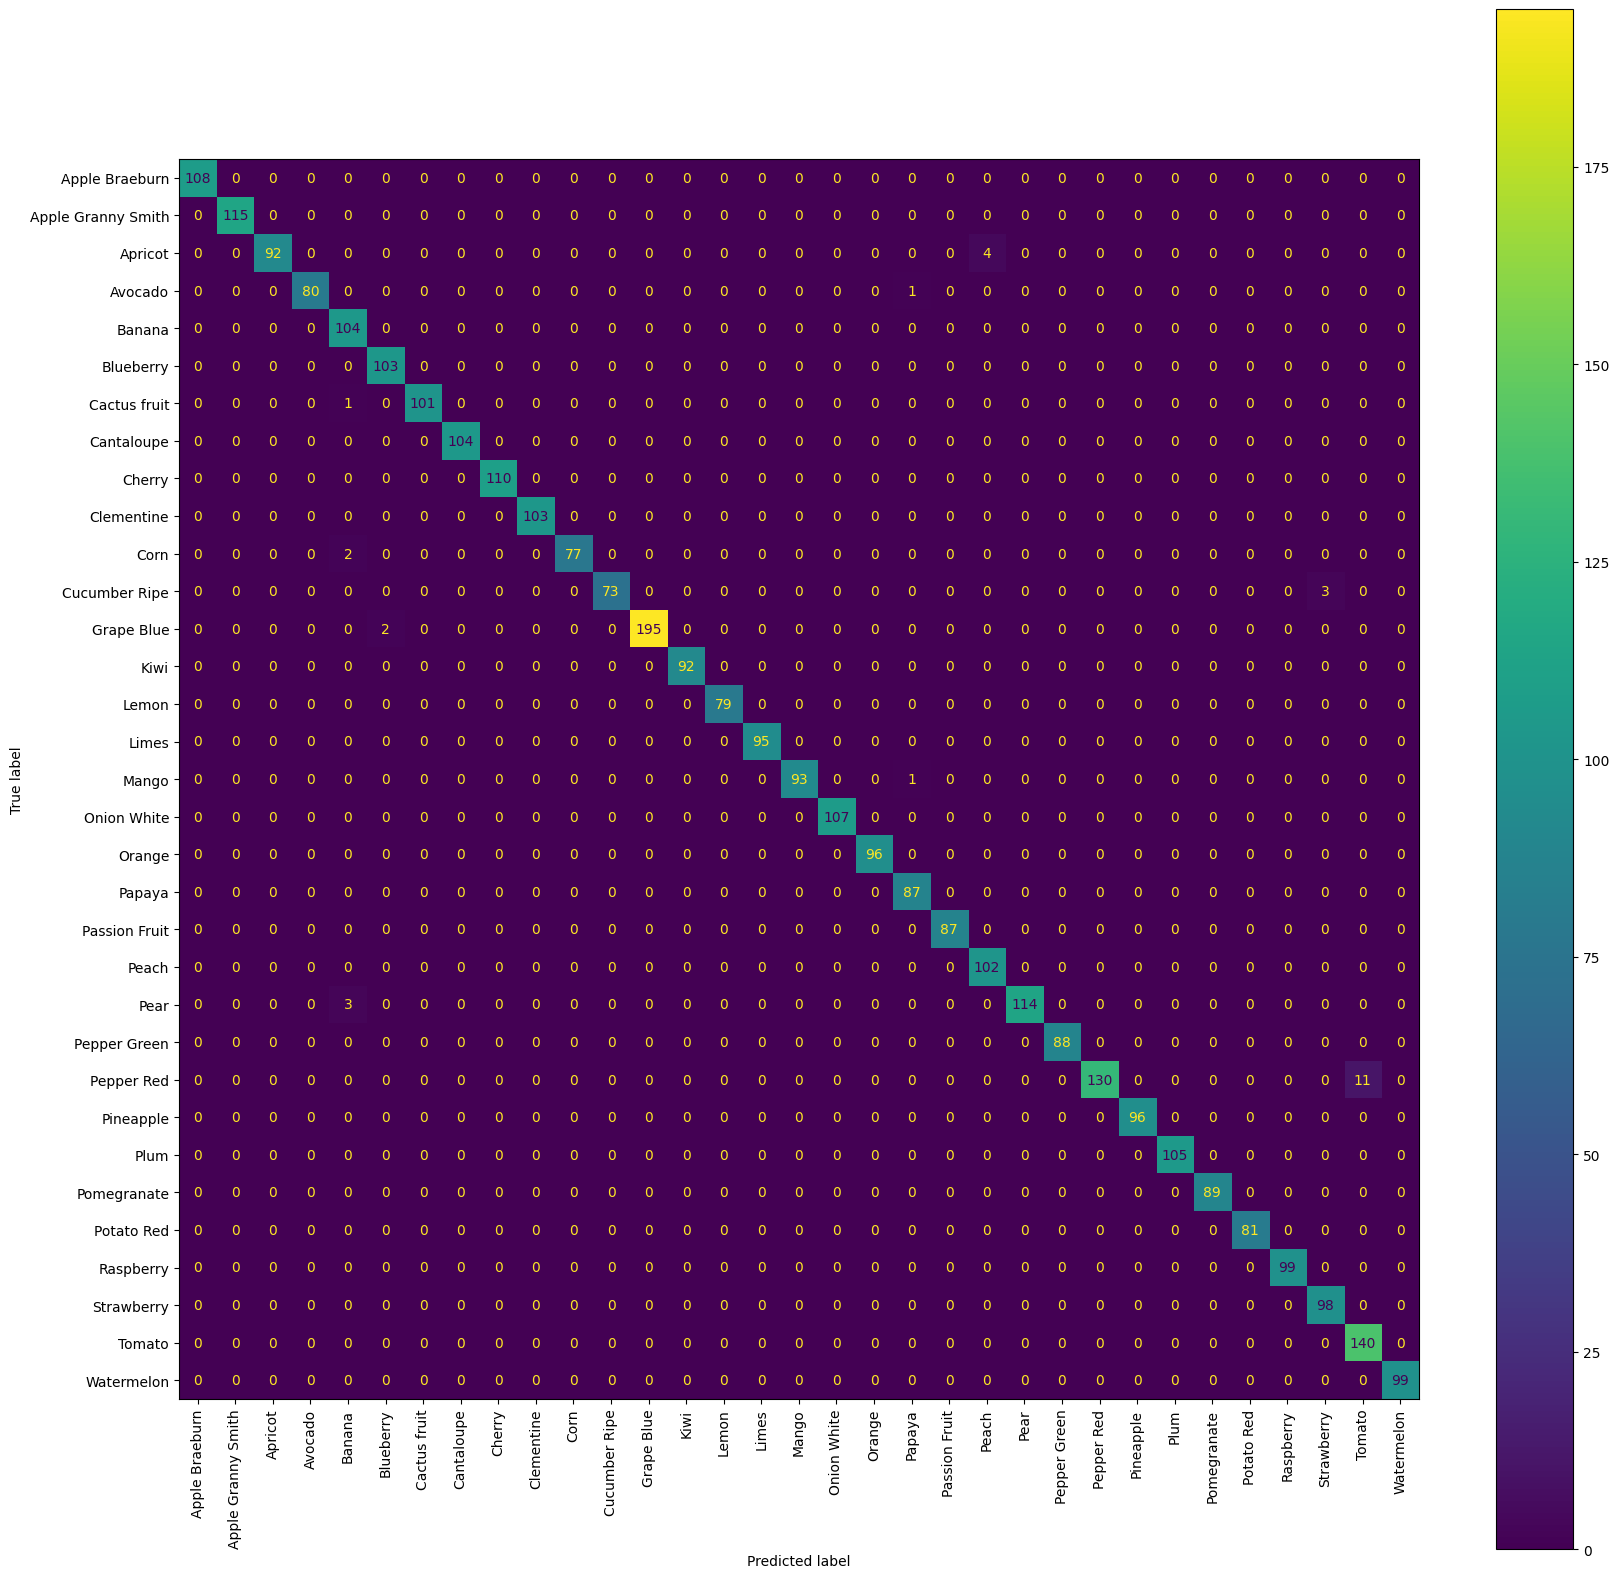

In [28]:
model = model.to(device)
model.eval()
 
y_pred = []
y_test = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y_pred_ = model(X)
        y_pred_ = y_pred_.argmax(-1).cpu()
        y_pred.extend(y_pred_)
        y_test.extend(y)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=dataset.classes)
plt.xticks(rotation=90)
plt.gcf().set_size_inches(20, 20)
plt.plot()